In [1]:
import numpy as np
import pandas as pd
import math
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.datasets import fetch_20newsgroups, load_iris
import copy as cp

[nltk_data] Downloading package wordnet to /Users/jian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<font size=6, color=blue>__Naive Bayes__</font>

<font size=6, color=black>__Part A__</font>

In [2]:
class Multinomial_NB:
    def __init__(self, alpha=1.0):
        return None
    
    def fit(self, X, y):
        self.X = np.asarray(X)
        self.y = y.tolist()
        self.alpha = alpha
        
    
    def parameter_matrix(self, X):
        class_num = len(np.unique(self.y)) #number of classes
        class_list = np.unique(self.y) #store all the classes
        sample_num = len(self.X)
        class_prior_list = np.zeros(class_num)
        class_count_list = np.zeros(class_num) #store number of appearance of each classes
        
        #print("Currrent X")
        #print(X.shape)
        #add up all class counts
        for i in range(class_num):
            for j in self.y:
                if j == class_list[i]:
                    class_count_list[i]+=1
        
        
        #calculate class prior and make them a list            
        for i in range(class_num):
            class_prior = (self.alpha+class_count_list[i])/(class_num+sample_num)
            class_prior_list[i] = class_prior
  
        #print('self.X shape: ', self.X.shape)
        
        #calculate feature likelihood
        feature_num = len(self.X[0])
        feature_vs_class_matrix = np.zeros((feature_num, class_num))
        
        
        
        #MJC
        for i in range(class_num): #iterate classes - y
            for j in range(feature_num): #iterate features - words
                for k in range(sample_num): #iterate samples - X
                    if self.y[k] == class_list[i]:
                        feature_vs_class_matrix[j][i] = feature_vs_class_matrix[j][i]+self.X[k][j]
        

        
        #MC: total number of features belongs to class C[i]
        words_vs_class = np.zeros(class_num) # Number of features in a class
        for i in range(class_num): #iterate classes - y
            for j in range(feature_num): #iterate features - words
                words_vs_class[i] = words_vs_class[i]+feature_vs_class_matrix[j][i]
        

        
        
        
        #feature likelihood matrix
        feature_likelihood = np.zeros((feature_num, class_num))
        for j in range(feature_num): #iterate features - words
            for i in range(class_num): #iterate classes - y
                feature_likelihood[j][i] = (feature_vs_class_matrix[j][i]+self.alpha)/(words_vs_class[i]+self.alpha*feature_num)
    
        return feature_likelihood, class_prior_list
    
    
    def predict(self, X):
        
        paras = self.parameter_matrix(X)
                
        
        #predict for each sample using class prior and feature likelihood
        log_likelihood = np.log2(paras[0])
        log_prior = np.log2(paras[1])
        
        pred_matrix = np.dot(X, log_likelihood)+np.transpose(log_prior) # sample*class
        
        predictions = np.argmax(pred_matrix, axis=1)
        
        #print("Predictions")
        #print(predictions)
        return predictions
    
    
    def predict_proba(self, X):
        paras = self.parameter_matrix(X)
        likelihood_proba = paras[0]
        prior_proba = paras[1]
        
        pred_matrix = np.dot(X, likelihood_proba)+np.transpose(prior_proba)
        return pred_matrix
    
    
    def predict_log_proba(self, X):
        paras = self.parameter_matrix(X)
                
        
        #predict for each sample using class prior and feature likelihood
        log_likelihood = np.log2(paras[0])
        log_prior = np.log2(paras[1])
        
        pred_matrix = np.dot(X, log_likelihood)+np.transpose(log_prior) # sample*class
        
        predictions = np.argmax(pred_matrix, axis=1)
        
        return pred_matrix

<font size=6, color=black>__Part B__</font>

In [3]:
df = pd.read_csv('SMSSpamCollection.csv', sep='\t')
df.columns=['label', 'text']
text = df['text']

In [4]:
df.head()

,label,text
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [5]:
df['length'] = df['text'].map(lambda text: len(text))
df.describe()

,length
count,5571.000000
mean,80.484473
std,59.946894
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


ham     4824
spam     747
Name: label, dtype: int64


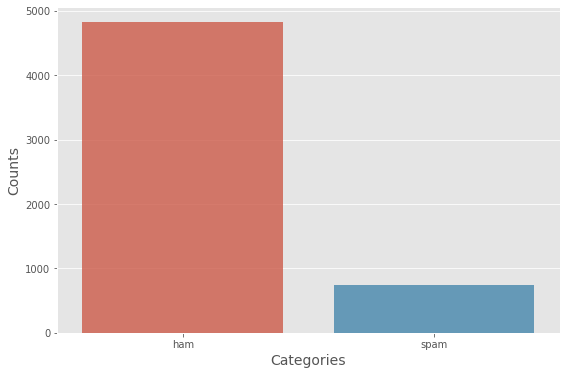

In [6]:
class_list = np.unique(df['label'])
print(df['label'].value_counts())
category = [df['label'].value_counts()[0], df['label'].value_counts()[1]]
plt.figure(figsize=(9,6))
sns.barplot(class_list, category, alpha=0.8)
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

<font size=6, color=black>__Part C__</font>

In [7]:
%%time
lemmatizer = WordNetLemmatizer()
text_lemmatized = []
for i in range(len(text)):
    text_lower = nltk.word_tokenize(text[i].lower())
    text_lemmatized.append(' '.join(lemmatizer.lemmatize(w) for w in text_lower))
print(text_lemmatized[5000])

well it not like you actually called someone a punto . that woulda been worse .
CPU times: user 3.44 s, sys: 102 ms, total: 3.55 s
Wall time: 3.58 s


In [8]:
%%time
stemmer = PorterStemmer()
text_stemmed = []
for i in range(len(text)):
    text_lower = nltk.word_tokenize(text[i].lower())
    text_stemmed.append(' '.join([stemmer.stem(w) for w in text_lower]))
print(text_stemmed[5000])

well it not like you actual call someon a punto . that woulda been wors .
CPU times: user 3.12 s, sys: 20.3 ms, total: 3.14 s
Wall time: 3.16 s



Ham Word Cloud:



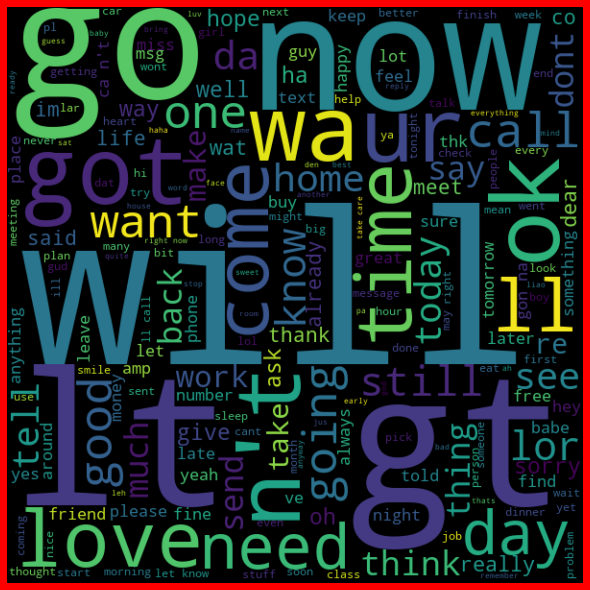


Spam Word Cloud:



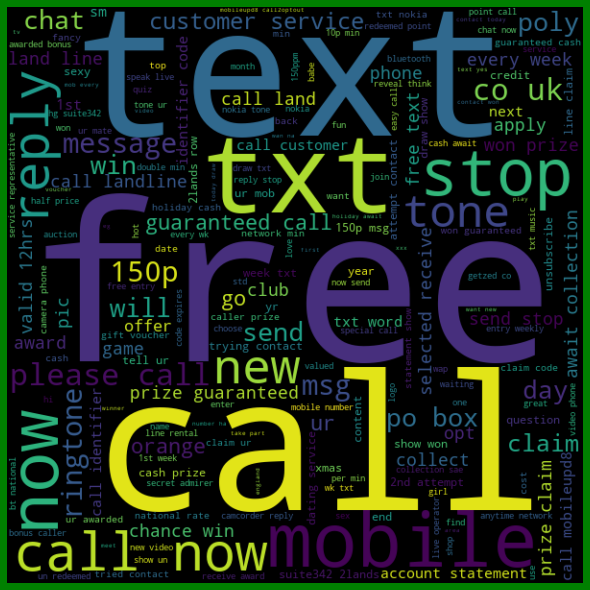

In [9]:
#Generate Word Cloud
lemmatizer = WordNetLemmatizer()
ham_lemmatized = []
spam_lemmatized = []
ham = df.loc[df['label'] == 'ham'].get('text').tolist()
spam = df.loc[df['label'] == 'spam'].get('text').tolist()
for i in range(len(ham)):
    ham_lower = nltk.word_tokenize(ham[i].lower())
    ham_lemmatized.append(' '.join(lemmatizer.lemmatize(w) for w in ham_lower))
    
for i in range(len(spam)):
    spam_lower = nltk.word_tokenize(spam[i].lower())
    spam_lemmatized.append(' '.join(lemmatizer.lemmatize(w) for w in spam_lower))

ham_wordcloud = WordCloud(width=600, height=600).generate(''.join(ham_lemmatized))
spam_wordcloud = WordCloud(width=600, height=600).generate(''.join(spam_lemmatized))

print('\nHam Word Cloud:\n') 
plt.figure(figsize=(15,8), facecolor='r')
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

print('\nSpam Word Cloud:\n')
plt.figure(figsize=(15,8), facecolor='g')
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [10]:
%%time
# Create Data Matrix for X and y
# Remove Stop Words
count_vect = CountVectorizer(lowercase=True, stop_words='english')
X = count_vect.fit_transform(text_lemmatized)
vocab = count_vect.vocabulary_

#text_unique = list(set(' '.join(vocab).split(' ')))

y = df['label']

#vectorize labels:

for i in range(len(y)):
    if y[i] == 'spam':
        y[i] = 1
    else:
        y[i] = 0

print(X.shape)
print(y.shape)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


(5571, 7961)
(5571,)
CPU times: user 1.02 s, sys: 12.5 ms, total: 1.03 s
Wall time: 1.03 s


In [11]:
X = X.toarray()
print(X)
X = pd.DataFrame(X)
X.columns = vocab

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: label, dtype: object

In [13]:
# Shuffle
df_new = pd.concat([y, X], axis=1)
df_new = df_new.sample(frac=1)
df_new.head()
X = df_new.drop(columns='label', axis=1)
y = df_new['label']

In [14]:
X.head()

,ok,lar,joking,wif,oni,free,entry,wkly,comp,win,...,dental,nmde,dump,heap,lowes,salesman,087187272008,now1,pity,bitching
5055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y.head(20)

5055    0
3609    0
1264    0
3716    0
2567    0
106     0
3274    0
5442    1
4342    0
4782    0
1928    1
4680    0
3735    0
2689    0
3671    0
1815    0
931     0
3927    0
3136    0
4202    0
Name: label, dtype: object

In [16]:
# Partition Data
#partition function to split data into train and test
def partitions(X, y, t):
    test_rows_X = math.ceil(len(X)*t)
    test_rows_y = math.ceil(len(y)*t)
    train_rows_X = len(X) - test_rows_X
    train_rows_y = len(y) - test_rows_y
    X_train = X.iloc[:train_rows_X]
    X_test = X.iloc[train_rows_X:]
    y_train = y[0:train_rows_y]
    y_test = y[train_rows_y:len(y)]

    return np.asarray([X_train, y_train, X_test, y_test])

In [17]:
par = partitions(X, y, 0.2)
X_train = par[0]
y_train = par[1]
X_test = par[2]
y_test = par[3]

In [18]:
print('Train Test Split Sizes:\n')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Train Test Split Sizes:

(4456, 7961)
(4456,)
(1115, 7961)
(1115,)


<font size=6, color=black>__Part D__</font>

In [19]:
#calculate tp, fp, tn, fn
#Function that returns accuracy and generalization error of two vectors
def accu_error(x, x_predict):
    g_error = np.mean((np.subtract(x, x_predict))**2)
    accu = 1 - g_error
    return (accu, g_error)

def values(x, x_predict):
    true_positive = 0.0
    false_positive = 0.0
    true_negative = 0.0
    false_negative = 0.0
    for i in range(len(x)):
        if np.logical_and(x_predict[i] == 1, x[i] == 1):
        #if x_predict[i] == 1 & x[i] == 1:
            true_positive += 1
        if np.logical_and(x_predict[i] == 1, x[i] == 0):
            false_positive += 1
        if np.logical_and(x_predict[i] == 0, x[i] == 0):
            true_negative += 1
        if np.logical_and(x_predict[i] == 0, x[i] == 1):
            false_negative += 1
          
    if(true_positive+false_negative == 0):
        tpr = 0.0
    else:
        tpr = (true_positive)/(true_positive+false_negative)
    if(false_positive+true_negative == 0):
        fpr = 0.0
    else:
        fpr = (false_positive)/(false_positive+true_negative)

    return [true_positive, false_positive, true_negative, false_negative, tpr, fpr]

#Function to compute precision
def precision(x, x_predict):
    tp = np.sum((x==1)&(x_predict==1))
    fp = np.sum((x==0)&(x_predict==1))
    if(tp+fp == 0):
        return 0.0 
    else:
        precisions = tp/(tp+fp)
    return precisions

#Function to compute recall
def recall(x, x_predict):
    tp = np.sum((x==1)&(x_predict==1))
    fn = np.sum((x==1)&(x_predict==0))
    if(tp+fn == 0):
        return 0.0
    else: 
        recall = tp/(tp+fn)
    return recall

#Function to compute f1
def f1_score(x, x_predict):
    if np.sum(x)+np.sum(x_predict) == 0:
        return 1.0
    if((precision(x,x_predict)+recall(x,x_predict)) == 0):
        return 0.0
    else:
        f1 = 2*((precision(x,x_predict)*recall(x,x_predict))/(precision(x,x_predict)+recall(x,x_predict)))
    return f1

#Function to compute confusion matrix
def confusion_matrix(x, x_predict):
    confusion_matrix = [[], []]
    confusion_matrix[0].append(values(x, x_predict)[2])
    confusion_matrix[0].append(values(x, x_predict)[1])
    confusion_matrix[1].append(values(x, x_predict)[3])
    confusion_matrix[1].append(values(x, x_predict)[0])
    return np.asarray(confusion_matrix)

In [20]:
def k_folds(X, cv):
    return [X[i::cv] for i in range(cv)]

def k_fold_f1(X, y, cv, model): # go horizontal
    train_set = []
    val_set = []
    y_train_true, y_train_pred = [], []
    y_val_true, y_val_pred = [], []
    f1_train, f1_val = [], []
    X_folds = k_folds(X, cv)
    y_folds = k_folds(y, cv)
    fold_len = math.ceil(len(X)/cv)
    tpr_list = []
    fpr_list = []
    #model.fit(X, y)
    for i in range(len(X_folds)):
        train_set = []
        val_set = []
        
        start = i*fold_len
        fin = start+fold_len

        X_train_set = np.delete(X,range(start,fin),0)
        y_train_set = np.delete(y,range(start,fin))
        model.fit(X_train_set, y_train_set)
        
        X_val_set = X_folds[i]
        y_val_true = y_folds[i]
        
        y_val_pred = model.predict(X_val_set)
        f1_val.append(f1_score(y_val_true, y_val_pred))
        
        vals = values(y_val_true, y_val_pred)
        tpr_list.append(vals[4])
        fpr_list.append(vals[5])
        
    return np.mean(f1_val), tpr_list, fpr_list

In [21]:
%%time
# Hyperparameter Tuning
alpha_list = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]
model = Multinomial_NB()
f1_scores_list = []
result = []
#X_train_temp = X_train.head(50)
#y_train_temp = y_train.head(50)
for i in alpha_list:
    alpha = i
    f1_scores_list.append(k_fold_f1(X_train.to_numpy(), y_train.to_numpy(), 5, model)[0])
    result.append({'alpha': i, 'mean f1 score': f1_scores_list[len(f1_scores_list)-1]})

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


CPU times: user 33min 52s, sys: 8.22 s, total: 34min
Wall time: 33min 42s


In [22]:
print(result)

[{'alpha': 0.0001, 'mean f1 score': 0.9683534425577509}, {'alpha': 0.001, 'mean f1 score': 0.9683534425577509}, {'alpha': 0.01, 'mean f1 score': 0.9700492726074191}, {'alpha': 0.1, 'mean f1 score': 0.9708499986620591}, {'alpha': 0.5, 'mean f1 score': 0.9711606529190646}, {'alpha': 1.0, 'mean f1 score': 0.972799757874409}, {'alpha': 1.5, 'mean f1 score': 0.9701319325811644}, {'alpha': 2.0, 'mean f1 score': 0.96697031729851}]


In [23]:
optimal_f1 = max(result[w].get('mean f1 score') for w in range(len(result)))
optimal_alpha = 0
for i in result:
    if i.get('mean f1 score') == optimal_f1:
        optimal_alpha = i.get('alpha')

print('The Optimal F1 Score is %f8(Alpha = %f)' % (optimal_f1, optimal_alpha))

The Optimal F1 Score is 0.9728008(Alpha = 1.000000)


In [24]:
#Function to generate ROC curve
def ROC_curve(fpr_list, tpr_list):
    plt.figure(figsize = (10, 6))
    plt.plot(fpr_list, tpr_list, color='orange', linewidth=5)
    #print(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve')

In [25]:
#Function to calculate the area under ROC
def auc(fpr_list, tpr_list):
    auc = np.trapz(tpr_list, fpr_list)
    return auc

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


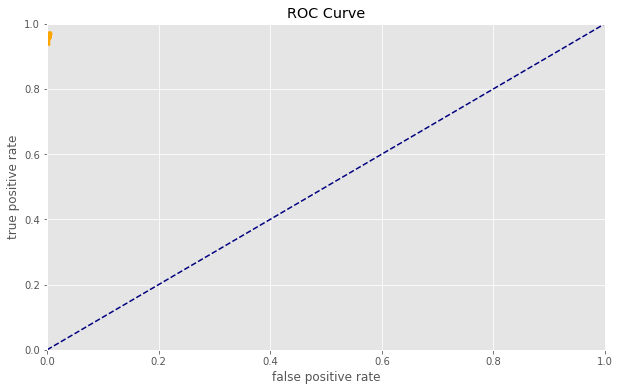

In [27]:
kfold = k_fold_f1(X_train.to_numpy(), y_train.to_numpy(), 5, Multinomial_NB())
ROC_curve(kfold[2], kfold[1])

In [28]:
auc(kfold[2], kfold[1])

0.002430795429789749

In [29]:
# Evaluate Model on Test Data
alpha = optimal_alpha
model_optimal = Multinomial_NB()
model_optimal.fit(X_train, y_train)
y_test_pred = model_optimal.predict(X_test)

In [30]:
print('Precision on Test Data: %f\n' %precision(y_test, y_test_pred))
print('Recall on Test Data: %f\n' %recall(y_test, y_test_pred))
print('F1 Score on Test Data: %f' %f1_score(y_test, y_test_pred))
print('\nConfusion Matrix:\n', confusion_matrix(y_test.to_numpy(), y_test_pred))
print('\nAccuracy on Test Data: %f' %accu_error(y_test, y_test_pred)[0])

Precision on Test Data: 0.885906

Recall on Test Data: 0.897959

F1 Score on Test Data: 0.891892

Confusion Matrix:
 [[951.  17.]
 [ 15. 132.]]

Accuracy on Test Data: 0.971300


<font size=6, color=blue>__Logistic Regression__</font>

<font size=6, color=black>__Part A__</font>

In [31]:
def one_hot_labels(Y):
    unique_classes = np.unique(Y)
    one_hot_label_list = np.zeros((len(unique_classes),len(unique_classes)))
    converted_Y = []
    for i in range(len(one_hot_label_list)):
        one_hot_label_list[i][i] = 1
    for i in range(len(Y)):
        for j in range(len(one_hot_label_list)):
            if Y[i] == unique_classes[j]:
                converted_Y.append(one_hot_label_list[j])
    return converted_Y

In [32]:
def softmax(score):
    return (np.exp(score.T)/np.sum(np.exp(score))).T

In [33]:
def cross_entropy_loss(Y_one_hot,Y_proba):
    loss = 0
    for i in range(len(Y_one_hot)):
        for c in range(len(Y_proba[0])):
            loss += Y_one_hot[i][c]*np.log(Y_proba[i][c])
    return -loss/len(Y_one_hot)

In [34]:
class Softmax_Regression:
    def calcRegCost(self,d,C,theta_new):
        cost = 0
        if self.regularizer == None:
            return 0
        elif self.regularizer == 'l1':
            for j in range(d):
                for c in range(C):
                    cost += theta_new[j][c]
            return self.lambd*cost/2
        else:
            for j in range(d):
                for c in range(C):
                    cost += theta_new[j][c]**2
            return self.lambd*cost/2
    def calcRegUpdate(self,theta):
        if self.regularizer == None:
            return 0
        elif self.regularizer == 'l1':
            return self.lambd*np.sign(theta)
        else:
            return self.lambd*theta
    
    def gradientDescent(self):
        N = len(self.X)
        d = len(self.X[0])
        C = len(np.unique(self.Y))
        one_hot_Y = one_hot_labels(self.Y)
        theta = np.zeros((d,C))
        theta_new = cp.deepcopy(theta)
        cost = 0
        cost_new = 0
        U = softmax(np.dot(self.X,theta))
        #U = softmax(np.dot(theta.T,self.X.T).T)
        for i in range(self.epochs):
            theta_new = cp.deepcopy(theta - (self.learning_rate/N)*(np.dot(self.X.T,(U-one_hot_Y))+self.calcRegUpdate(theta)))
            U_new = softmax(np.dot(self.X,theta_new))
            #U_new = cp.deepcopy(softmax(np.dot(theta_new.T,self.X.T).T))
            
            cost_new = cross_entropy_loss(one_hot_Y,U_new) + self.calcRegCost(d,C,theta_new)
            if abs(cost-cost_new) < self.tol:
                return theta
                break
            theta = cp.deepcopy(theta_new)
            cost = cost_new
            U = cp.deepcopy(U_new)
        return theta
            
    
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, early_stopping=False, validation_fraction=0.1, **kwargs):
        self.X = X
        self.Y = Y
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.theta = self.gradientDescent()
        
    def predict(self,X):
        predictions = np.dot(X,self.theta)
        final_predictions = []
        unique_classes = np.unique(self.Y)
        for i in range(len(predictions)):
            for j in range(len(unique_classes)):
                if j == np.argmax(predictions[i]):
                    final_predictions.append(unique_classes[j])
                    break;
        return final_predictions
    
    def __init__(self):
        return None

<font size=6, color=black>__Part B__</font>

In [35]:
data = load_iris()
df = pd.DataFrame(data = np.c_[data['data'], data['target']],columns=data.feature_names + ['target'])
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [36]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [37]:
df = df.sample(frac=1)
X = df.drop(columns=['target'])
y = df['target'].to_numpy()
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
124,6.7,3.3,5.7,2.1,2.0
61,5.9,3.0,4.2,1.5,1.0
108,6.7,2.5,5.8,1.8,2.0
33,5.5,4.2,1.4,0.2,0.0
49,5.0,3.3,1.4,0.2,0.0


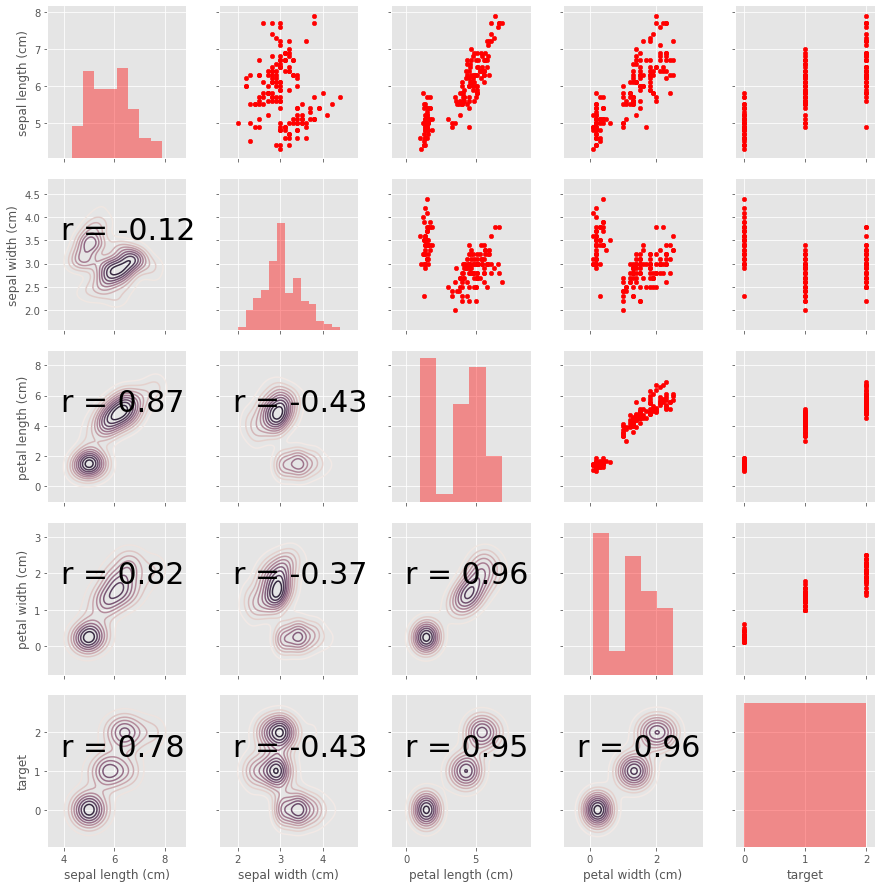

In [38]:
#generate pair plots for redundant features
def corrfunc(x, y, **kws):
    r,_ = stats.pearsonr(x,y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
               xy=(.1, .6), xycoords=ax.transAxes,
               size = 30)
cmap = sns.cubehelix_palette(light=1, dark=0.1,
                            hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

g = sns.PairGrid(df)

g.map_upper(plt.scatter, s=20, color='red')

g.map_diag(sns.distplot, kde=False, color='red')

g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [39]:
#standardize
X_mean = np.mean(X.T)
X_std = np.std(X.T)

X_standard = ((X.T-X_mean)/(X_std)).T

In [40]:
# Partition Data
#partition function to split data into train and test
def partitions(X, y, t):
    test_rows_X = math.ceil(len(X)*t)
    test_rows_y = math.ceil(len(y)*t)
    train_rows_X = len(X) - test_rows_X
    train_rows_y = len(y) - test_rows_y
    #X_train = X.iloc[:train_rows_X]
    #X_test = X.iloc[train_rows_X:]
    X_train = X[0:train_rows_X]
    X_test = X[train_rows_X:len(X)]
    y_train = y[0:train_rows_y]
    y_test = y[train_rows_y:len(y)]

    return np.asarray([X_train, y_train, X_test, y_test])

In [41]:
par = partitions(X_standard, y, 0.2)
X_train = par[0]
y_train = par[1]
X_test = par[2]
y_test = par[3]

In [42]:
print('Train Test Split Sizes:\n')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Train Test Split Sizes:

(120, 4)
(120,)
(30, 4)
(30,)


<font size=6, color=black>__Part C__</font>

In [43]:
def k_folds(X, cv):
    return [X[i::cv] for i in range(cv)]

def k_fold_accu_error(X, y, cv, model,learning_rate,tol,regularizer,lambd): # go horizontal
    val_set = []
    y_val_true, y_val_pred = [], []
    error_val = []
    X_folds = k_folds(X, cv)
    y_folds = k_folds(y, cv)
    fold_len = math.ceil(len(X)/cv)
    for i in range(len(X_folds)):
        start = i*fold_len
        fin = start+fold_len
        X_train_set = np.delete(X,range(start,fin),0)
        y_train_set = np.delete(y,range(start,fin))
        model.fit(X_train_set, y_train_set, learning_rate, 1000, tol, regularizer, lambd)
        y_val_true = y_folds[i]
        y_val_pred = model.predict(X_folds[i])
        error_val.append(accu_error(y_val_true, y_val_pred)[0])
    return np.mean(error_val)

In [44]:
%%time
lambd = [.1,.01,.001,.0001]
tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
learning_rate = [0.1, 0.01, 0.001]
regularizer= ['l1', 'l2']
all_accuracies = []
model = Softmax_Regression()
for i in lambd:
    for j in tol:
        for k in learning_rate:
            for l in regularizer:
                all_accuracies.append({'lambd':i,'tol':j,'learning_rate':k,'regularizer':l,'accuracy':k_fold_accu_error(X_train.to_numpy(),y_train,5,model,k,j,l,i)})

CPU times: user 5min 39s, sys: 1.11 s, total: 5min 41s
Wall time: 5min 42s


In [45]:
all_accuracies

[{'lambd': 0.1,
  'tol': 0.001,
  'learning_rate': 0.1,
  'regularizer': 'l1',
  'accuracy': 0.7166666666666666},
 {'lambd': 0.1,
  'tol': 0.001,
  'learning_rate': 0.1,
  'regularizer': 'l2',
  'accuracy': 0.7166666666666666},
 {'lambd': 0.1,
  'tol': 0.001,
  'learning_rate': 0.01,
  'regularizer': 'l1',
  'accuracy': 0.7166666666666666},
 {'lambd': 0.1,
  'tol': 0.001,
  'learning_rate': 0.01,
  'regularizer': 'l2',
  'accuracy': 0.7083333333333333},
 {'lambd': 0.1,
  'tol': 0.001,
  'learning_rate': 0.001,
  'regularizer': 'l1',
  'accuracy': 0.7083333333333333},
 {'lambd': 0.1,
  'tol': 0.001,
  'learning_rate': 0.001,
  'regularizer': 'l2',
  'accuracy': 0.7083333333333333},
 {'lambd': 0.1,
  'tol': 0.0001,
  'learning_rate': 0.1,
  'regularizer': 'l1',
  'accuracy': 0.7249999999999999},
 {'lambd': 0.1,
  'tol': 0.0001,
  'learning_rate': 0.1,
  'regularizer': 'l2',
  'accuracy': 0.7416666666666666},
 {'lambd': 0.1,
  'tol': 0.0001,
  'learning_rate': 0.01,
  'regularizer': 'l1',

In [46]:
optimal_index = 0
for i in range(len(all_accuracies)):
    if all_accuracies[i]['accuracy'] > all_accuracies[optimal_index]['accuracy']:
        optimal_index = i

In [47]:
optimal_lambd = all_accuracies[optimal_index]['lambd']
optimal_tol = all_accuracies[optimal_index]['tol']
optimal_learning_rate = all_accuracies[optimal_index]['learning_rate']
optimal_regularizer = all_accuracies[optimal_index]['regularizer']
optimal_model = Softmax_Regression()
optimal_model.fit(X_train.to_numpy(),y_train,lambd = optimal_lambd,tol=optimal_tol,learning_rate=optimal_learning_rate,regularizer=optimal_regularizer)
accu_error(y_test,optimal_model.predict(X_test))[0]

0.6666666666666667

In [48]:
# Evaluate on Test Data
print('Accuracy of the Test Data: %f' %accu_error(y_test,optimal_model.predict(X_test))[0])
print('\nConfusion Matrix:\n', confusion_matrix(y_test,optimal_model.predict(X_test)))

Accuracy of the Test Data: 0.666667

Confusion Matrix:
 [[10.  0.]
 [ 0.  9.]]
